In [1]:
import os
import pandas as pd
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange
from tqdm import tqdm_notebook
import seaborn as sns

from collections import Counter

%matplotlib inline

In [2]:
from ipywidgets import IntProgress

In [3]:
train_csv_file = "../data/train.csv"
TRAIN_DIR = "../data/train/train/"

In [4]:
# plot imgs
def plot_images_from_filename(filenames, labels, rows=4):
    imgs = [plt.imread(f'{TRAIN_DIR}{filename}') for filename in filenames]
    plot_images(imgs, labels, rows)

def plot_images(imgs, labels, rows):
    figure = plt.figure(figsize=(12, 8))
    
    cols = len(imgs) // rows + 1
    
    for i in tqdm(range(len(imgs))):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap=plt.cm.gray)

In [5]:
train_csv = pd.read_csv(train_csv_file)

In [6]:
np.random.seed(40)

In [7]:
train_csv.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [8]:
# 随机抽取图片查看
rand_rows = train_csv.sample(frac=1.)[:20]
imgs = list(rand_rows["Image"])
Ids = list(rand_rows["Id"])

100%|██████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


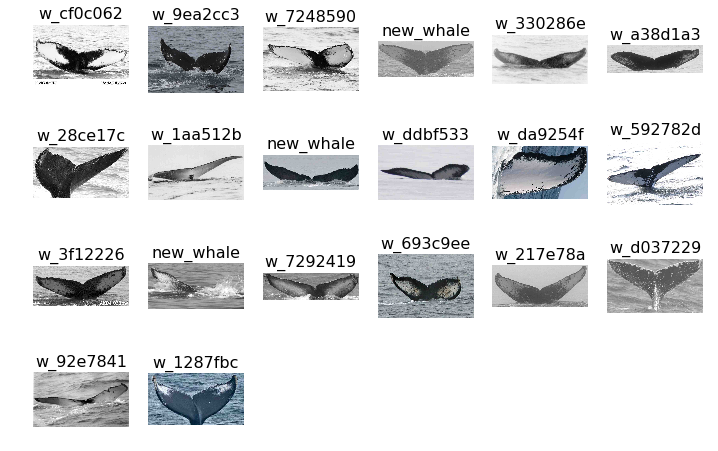

In [9]:
plot_images_from_filename(imgs, Ids)

In [10]:
# 查看类别数
num_categories = train_csv['Id'].unique().shape[0]
print(f'Number of categories: {num_categories}')

# 查看总的图片数
num_images = len(train_csv['Id'])
print(f'Number of all images: {num_images}')

Number of categories: 4251
Number of all images: 9850


In [11]:
size_buckets = Counter(train_csv['Id'].value_counts().values)

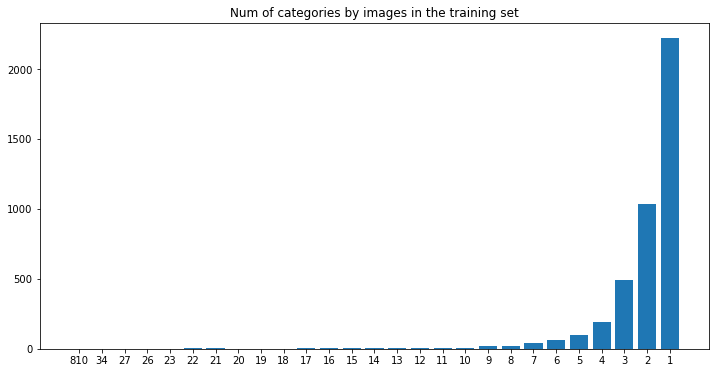

In [12]:
plt.figure(figsize=(12, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values()))
plt.xticks(range(len(size_buckets)), list(size_buckets.keys()))

plt.title("Num of categories by images in the training set")
plt.show()

In [13]:
train_csv['Id'].value_counts().head()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: Id, dtype: int64

100%|██████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


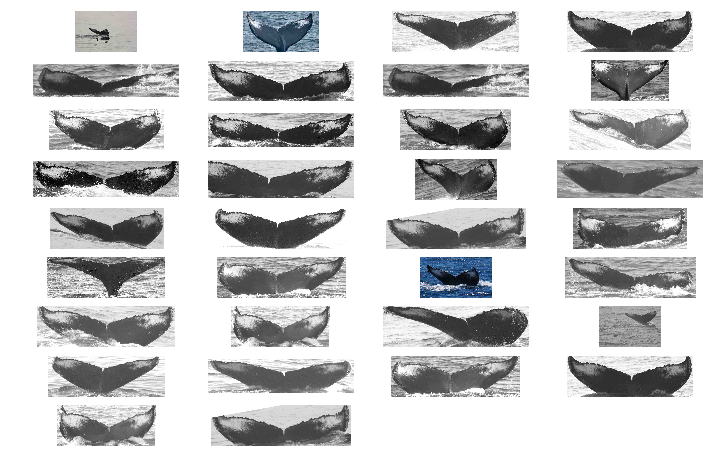

In [14]:
# 查看某一类别的图片
w_1287fbc = train_csv[train_csv['Id']=='w_1287fbc']
plot_images_from_filename(w_1287fbc['Image'], None, rows=9)

100%|██████████████████████████████████████████| 27/27 [00:02<00:00,  9.77it/s]


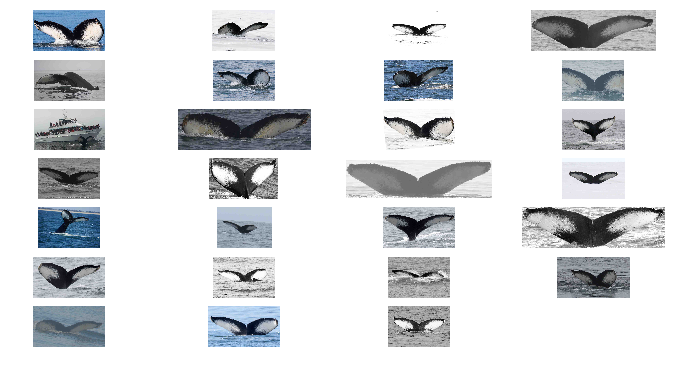

In [15]:
# 查看某一类别的图片
w_98baff9 = train_csv[train_csv['Id']=='w_98baff9']
plot_images_from_filename(w_98baff9['Image'], None, rows=9)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 15.78it/s]


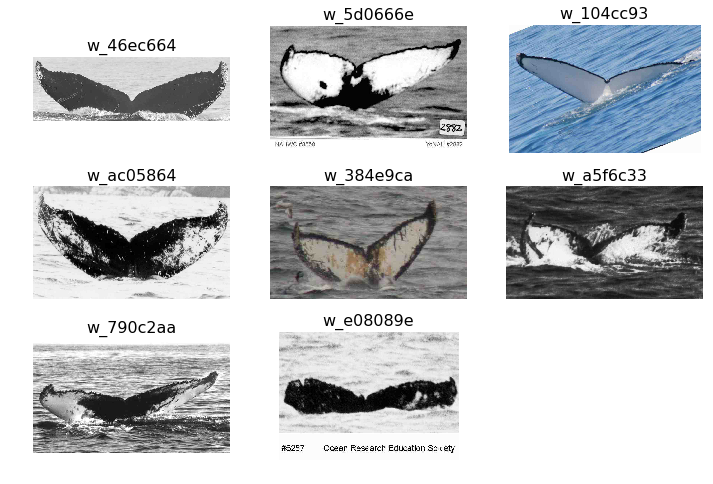

In [16]:
# 查看只有一类的图片
one_image_ids = train_csv['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_csv[train_csv['Id']==i]['Image']))
    labels.append(i)
    
plot_images_from_filename(one_image_filenames, labels, rows=3)

In [17]:
# 判断是否是灰度图
def is_grey_scale(img_path):
    im = Image.open(img_path).convert('RGB')
    w, h = im.size
    for i in range(w):
        for j in range(h):
            r, g, b = im.getpixel((i, j))
            if r!=g!=b:
                return False
    return True

In [18]:
im = Image.open(f'{TRAIN_DIR}c6eff2fd.jpg').convert('RGB')
r, g, b = im.getpixel((1, 1))

In [19]:
is_grey = [is_grey_scale(f'{TRAIN_DIR}{i}') for i in tqdm(train_csv['Image'].sample(frac=0.1))]

100%|████████████████████████████████████████| 985/985 [04:46<00:00,  1.98it/s]


In [20]:
grey_prec = round(sum([i for i in is_grey]) / len([i for i in is_grey])*100, 2)
print(f'% of grey images: {grey_prec}')

% of grey images: 48.43


100%|████████████████████████████████████| 9850/9850 [00:02<00:00, 4734.55it/s]


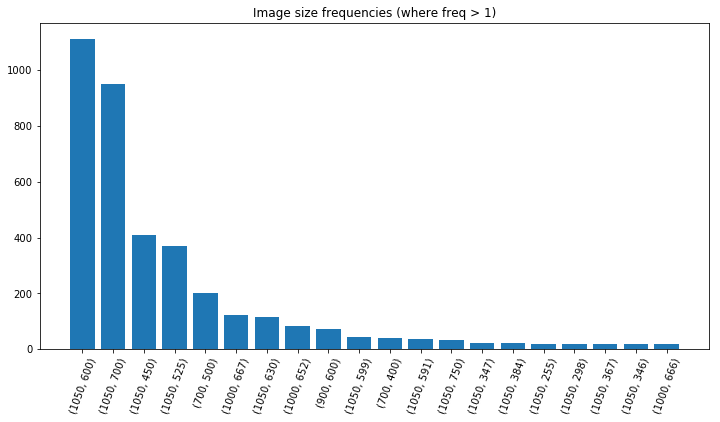

In [21]:
# 统计图片大小的分布
img_sizes = Counter([Image.open(f'{TRAIN_DIR}{i}').size for i in tqdm(train_csv['Image'])])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(12, 6))

plt.bar(range(len(freq)), list(freq))
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

# Data Augmentation

In [36]:
from keras.preprocessing import image
from keras.preprocessing.image import (random_rotation, random_shift, random_shear, random_zoom, random_channel_shift, img_to_array)
from scipy import ndimage

In [23]:
img = Image.open(f'{TRAIN_DIR}ff38054f.jpg')

In [24]:
img_arr = img_to_array(img)

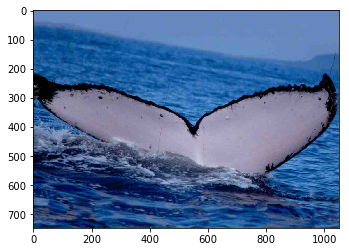

In [25]:
plt.imshow(img)

## random ratotion

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]


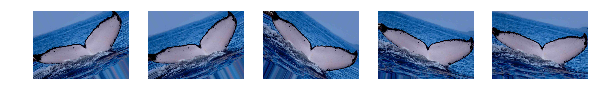

In [46]:
imgs = [ random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') /255  for _ in range(5) ]

plot_images(imgs, None, rows = 1)

## random shift

100%|████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


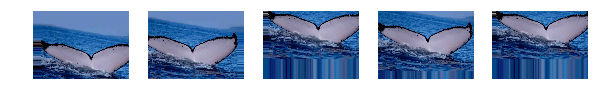

In [49]:
imgs = [ random_shift(img_arr, wrg=0.1, hrg=0.3, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')/255 for _ in range(5)]

plot_images(imgs, None, rows=1)

## random shear

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 15.33it/s]


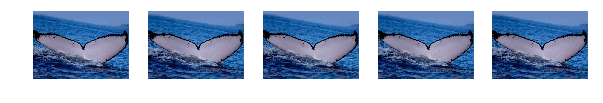

In [51]:
imgs = [
    random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') / 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

## random zoom

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 14.96it/s]


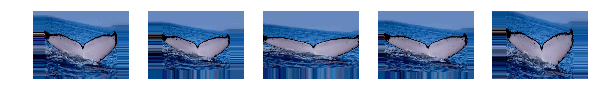

In [53]:
imgs = [
    random_zoom(img_arr, zoom_range=(1.5, 0.7), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') / 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 15.76it/s]


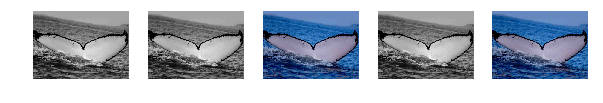

In [65]:
import random

def random_greyscale(img, p):
    if random.random() < p:
        return np.dot(img[..., :3], [0.299, 0.587, 0.114])
    return img

imgs = [
    random_greyscale(img_arr, 0.5) * 255
    for _ in range(5)]

plot_images(imgs, None, rows=1)

## all together

In [66]:
def augmentatin_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.9, 2.0), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_greyscale(img_arr, 0.4)

    return img_arr

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 14.40it/s]


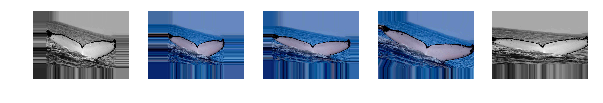

In [69]:
imgs = [ augmentatin_pipeline(img_arr) / 255 for _ in range(5) ]

plot_images(imgs, None, rows=1)